LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

Personal Loan
EMI Free Loan
Personal Overdraft
Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

### Understanding the data

loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

term : The number of payments on the loan. Values are in months and can be either 36 or 60.

int_rate : Interest Rate on the loan

installment : The monthly payment owed by the borrower if the loan originates.

grade : LoanTap assigned loan grade

sub_grade : LoanTap assigned loan subgrade

emp_title :The job title supplied by the Borrower when applying for the loan.*

emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.

annual_inc : The self-reported annual income provided by the borrower during registration.

verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified

issue_d : The month which the loan was funded

loan_status : Current status of the loan - Target Variable

purpose : A category provided by the borrower for the loan request.

title : The loan title provided by the borrower

dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.

earliest_cr_line :The month the borrower's earliest reported credit line was opened

open_acc : The number of open credit lines in the borrower's credit file.

pub_rec : Number of derogatory public records

revol_bal : Total credit revolving balance

revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

total_acc : The total number of credit lines currently in the borrower's credit file

initial_list_status : The initial listing status of the loan. Possible values are – W, F

application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers

mort_acc : Number of mortgage accounts.

pub_rec_bankruptcies : Number of public record bankruptcies

Address: Address of the individual

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
import warnings

In [4]:
df = pd.read_csv("logistic_regression.csv")
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [5]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [7]:
for i in df.columns:
    print(i, '-->> ', df[i].unique(), '\n')

loan_amnt -->>  [10000.  8000. 15600. ... 36275. 36475.   725.] 

term -->>  [' 36 months' ' 60 months'] 

int_rate -->>  [11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11 14.64
  9.17 12.29  6.62  8.39 21.98  7.9   6.97  6.99 15.61 11.36 13.35 12.12
  9.99  8.19 18.75  6.03 14.99 16.78 13.67 13.98 16.99 19.91 17.86 21.49
 12.99 18.54  7.89 17.1  18.25 11.67  6.24  8.18 12.35 14.16 17.56 18.55
 22.15 10.39 15.99 16.07 24.99  9.67 19.19 21.   12.69 10.74  6.68 19.22
 11.49 16.55 19.97 24.7  13.49 18.24 16.49 25.78 25.83 18.64  7.51 13.99
 15.22 15.31  7.69 19.53 10.16  7.62  9.75 13.68 15.88 14.65  6.92 23.83
 10.75 18.49 20.31 17.57 27.31 19.99 22.99 12.59 10.37 14.33 13.53 22.45
 24.5  17.99  9.16 12.49 11.55 17.76 28.99 23.1  20.49 22.7  10.15  6.89
 19.52  8.9  14.3   9.49 25.99 24.08 13.05 14.98 16.59 11.26 25.89 14.48
 21.99 23.99  5.99 14.47 11.53  8.67  8.59 10.64 23.28 25.44  9.71 16.2
 19.24 24.11 15.8  15.96 14.49 18.99  5.79 19.29 14.54 14.09  9.25 19.05
 17

In [8]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [9]:
df.dropna(inplace=True)

Dropping all null values

In [10]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
title                   0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
dtype: int64

In [11]:
df.shape

(335867, 27)

In [12]:
df.duplicated().sum()

0

There are no duplicates in the dataset


## Univariate Analysis

In [13]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [14]:
float_columns = df.select_dtypes(include=['float64']).columns
float_columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

In [15]:
df_float = df[float_columns]
df_float

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,10000.0,11.44,329.48,117000.0,26.24,16.0,0.0,36369.0,41.8,25.0,0.0,0.0
1,8000.0,11.99,265.68,65000.0,22.05,17.0,0.0,20131.0,53.3,27.0,3.0,0.0
2,15600.0,10.49,506.97,43057.0,12.79,13.0,0.0,11987.0,92.2,26.0,0.0,0.0
3,7200.0,6.49,220.65,54000.0,2.60,6.0,0.0,5472.0,21.5,13.0,0.0,0.0
4,24375.0,17.27,609.33,55000.0,33.95,13.0,0.0,24584.0,69.8,43.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
396024,6000.0,13.11,202.49,64000.0,10.81,7.0,0.0,11456.0,97.1,9.0,0.0,0.0
396025,10000.0,10.99,217.38,40000.0,15.63,6.0,0.0,1990.0,34.3,23.0,0.0,0.0
396026,21000.0,12.29,700.42,110000.0,21.45,6.0,0.0,43263.0,95.7,8.0,1.0,0.0
396027,5000.0,9.99,161.32,56500.0,17.56,15.0,0.0,32704.0,66.9,23.0,0.0,0.0


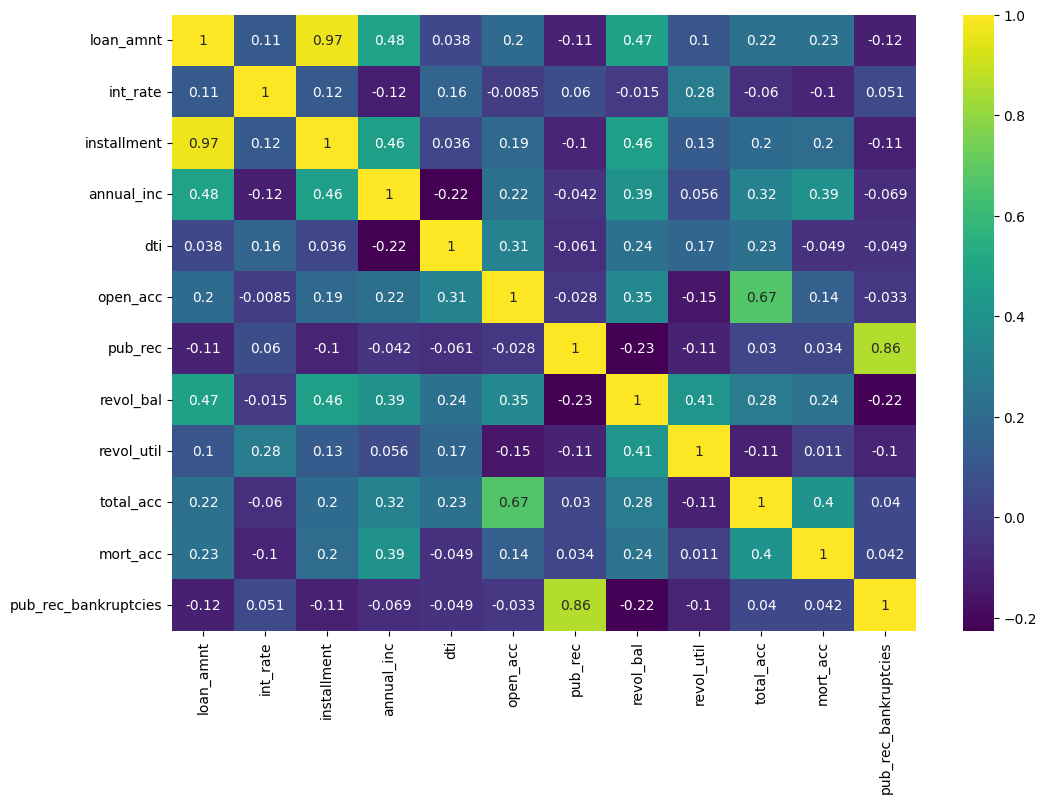

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df_float.corr(method='spearman'),annot=True,cmap='viridis')
plt.show()

We noticed almost perfect correlation between "loan_amnt" the "installment" feature.

installment: The monthly payment owed by the borrower if the loan originates.
loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
So, we can drop either one of those columns.

In [17]:
df.drop(columns=['installment'],axis=1,inplace=True)
df_float.drop(columns=['installment'],axis=1,inplace=True)

C:\Users\Rhythm Shah\AppData\Local\Temp\ipykernel_22880\546979441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_float.drop(columns=['installment'],axis=1,inplace=True)


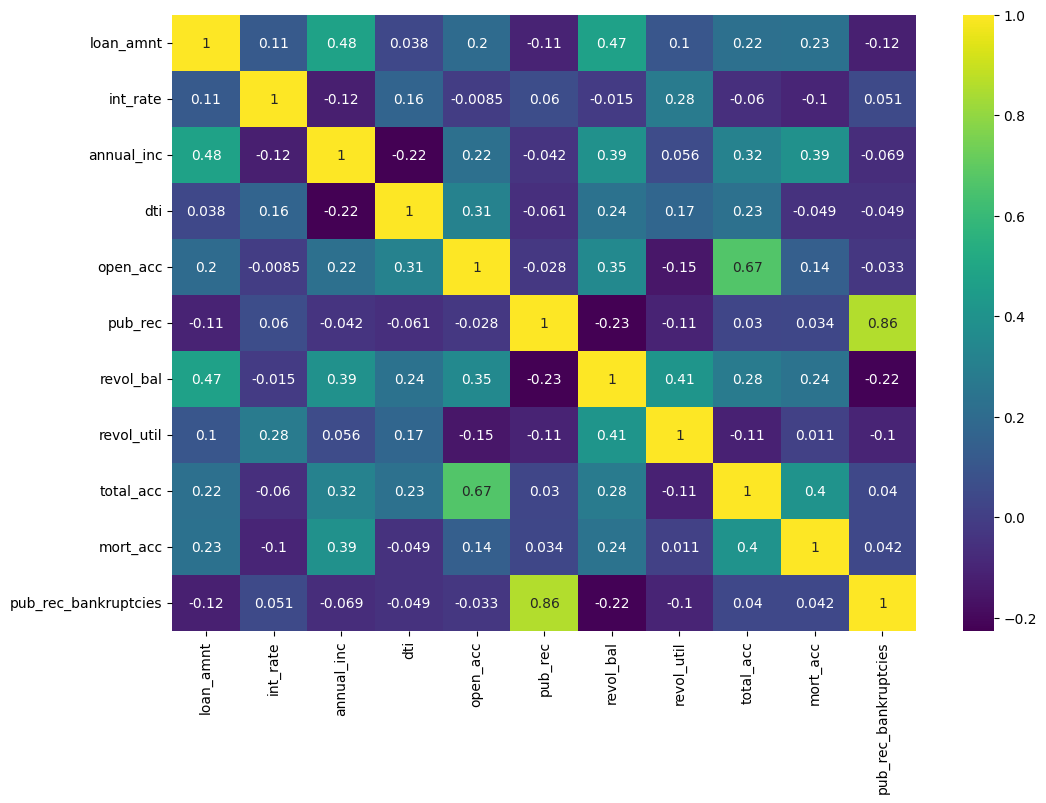

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df_float.corr(method='spearman'),annot=True,cmap='viridis')
plt.show()

In [19]:
univariate_cols = df.select_dtypes('float64').columns.tolist()

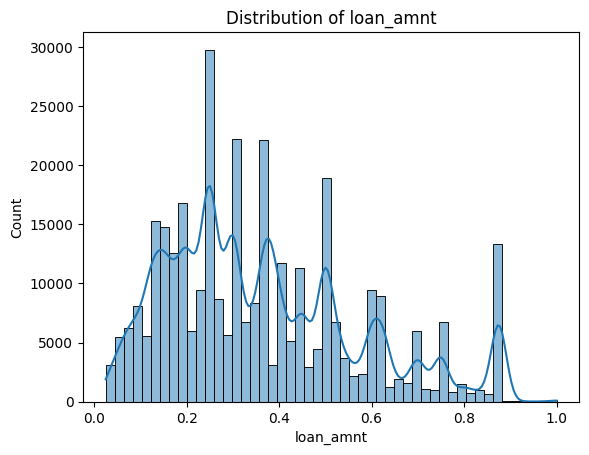

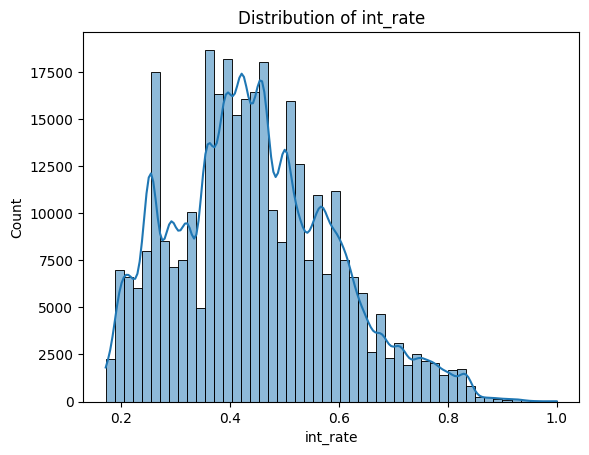

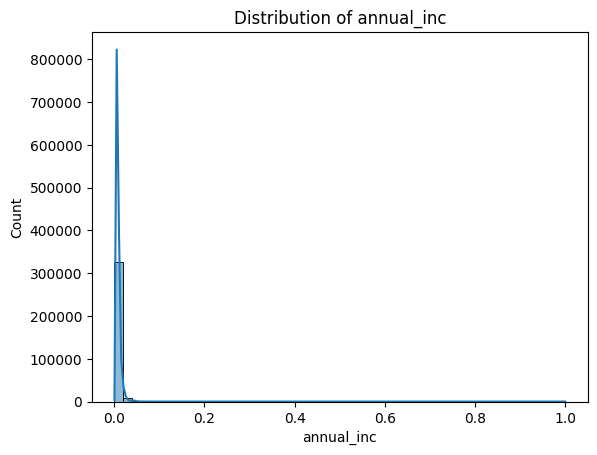

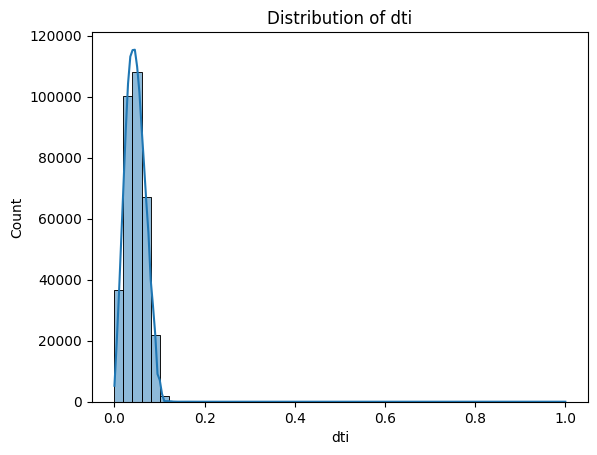

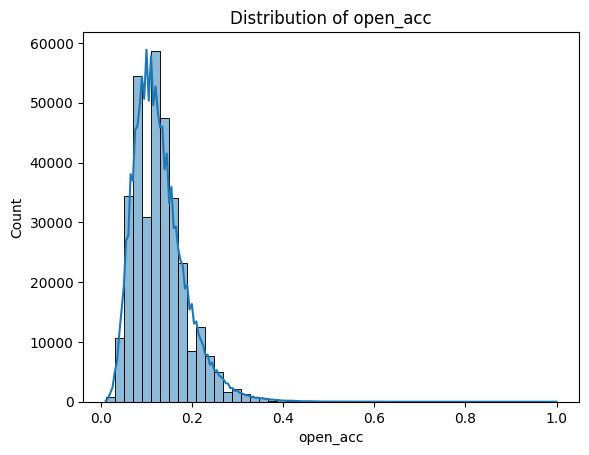

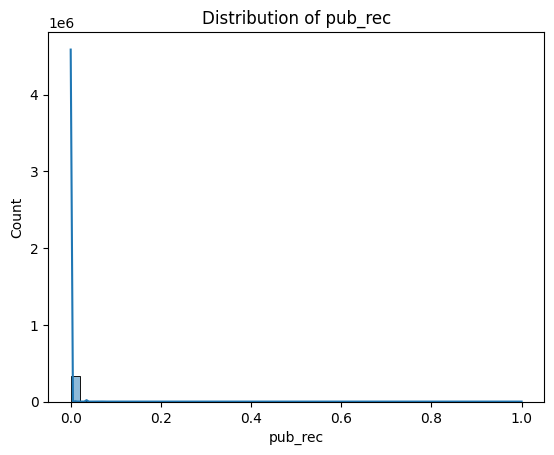

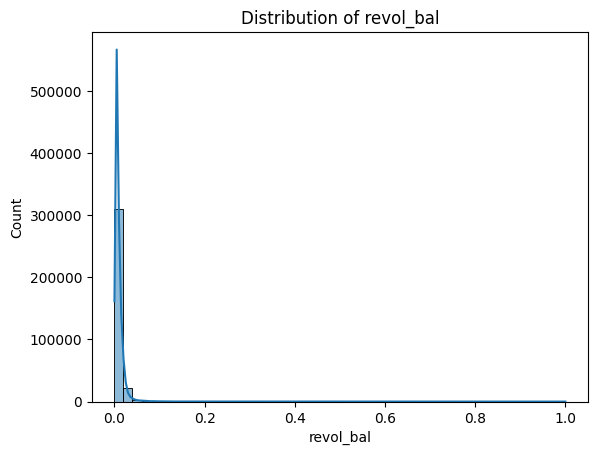

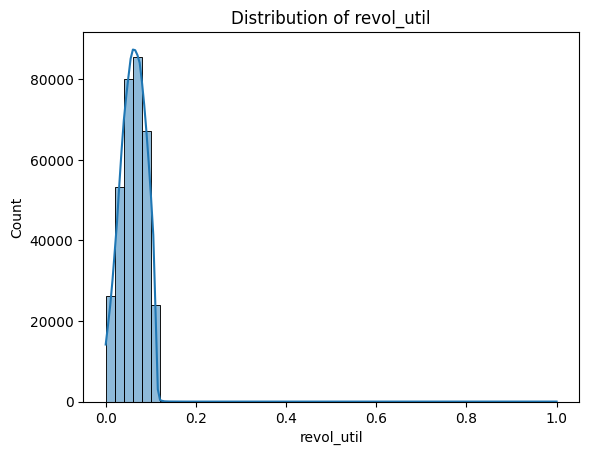

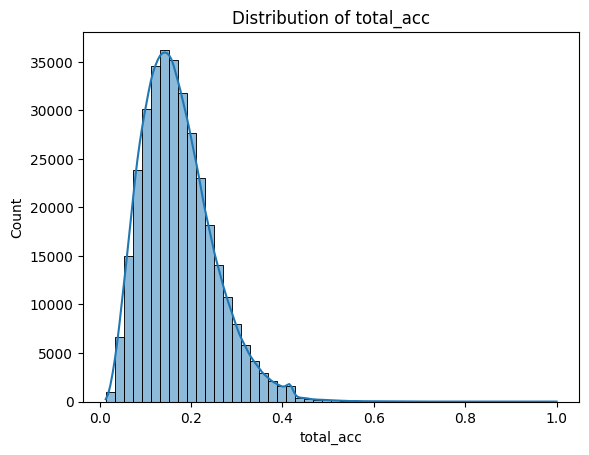

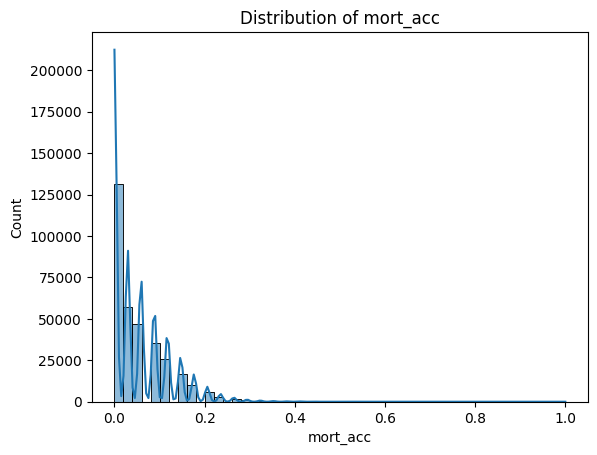

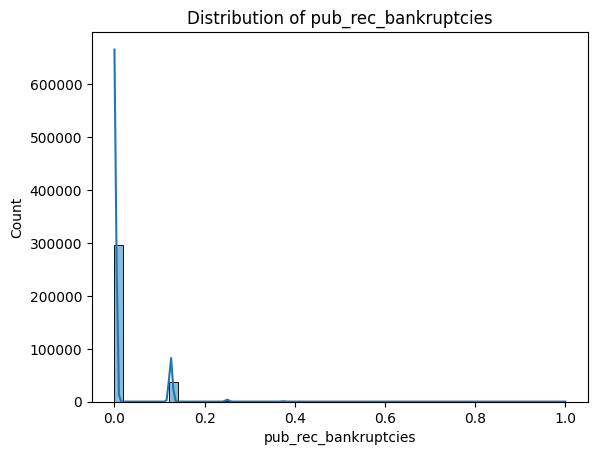

In [20]:
for i in univariate_cols:
#     plt.figure(figsize=(12,5))
    plt.title("Distribution of {}".format(i))
    sns.histplot(df[i]/df[i].max(), kde=True, bins=50)
    plt.show()

Most of the distribution is highly skewed which tells us that they might contain outliers
Almost all the continuous features have outliers present in the dataset. They have to be standarsised


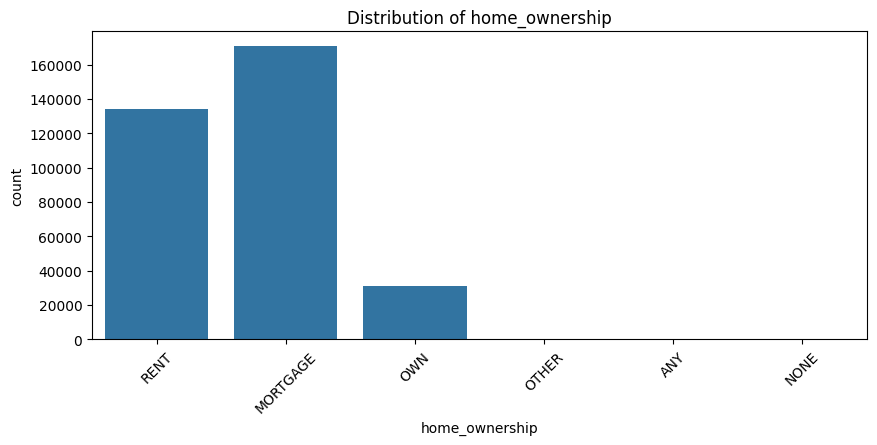

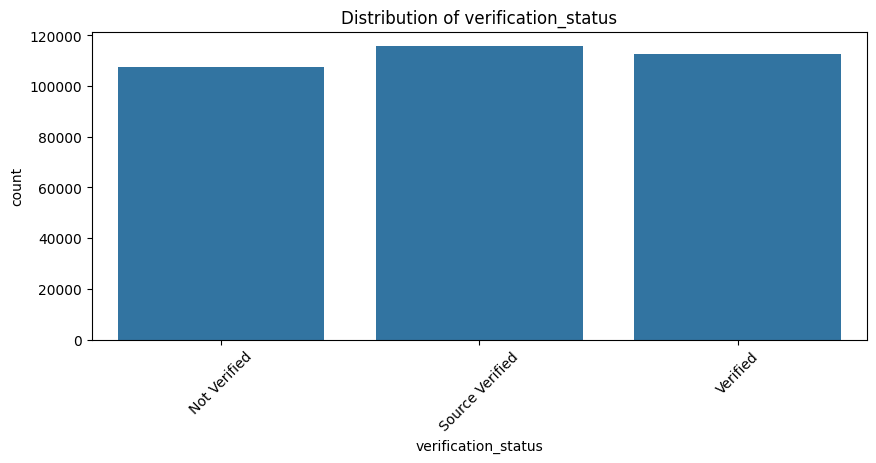

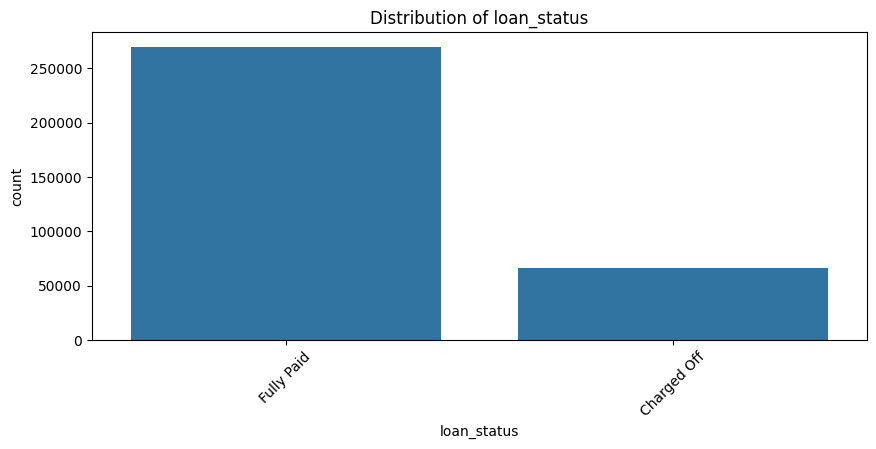

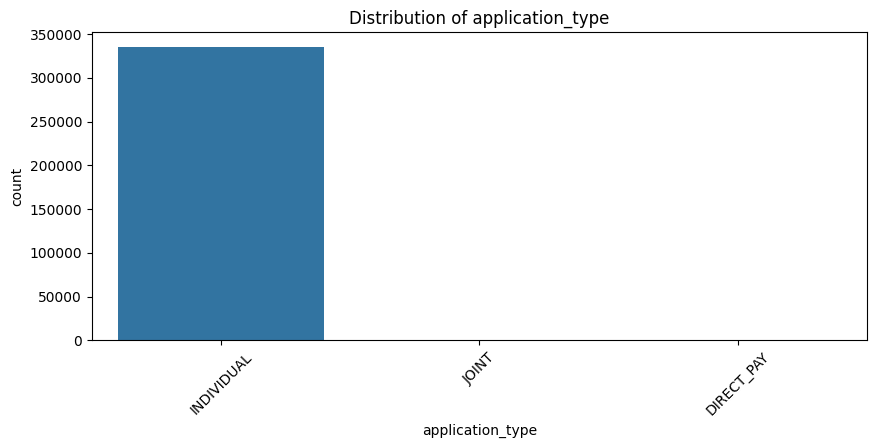

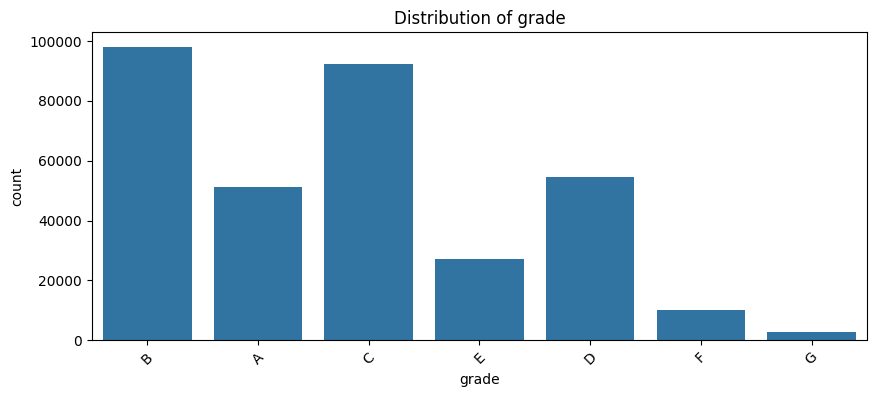

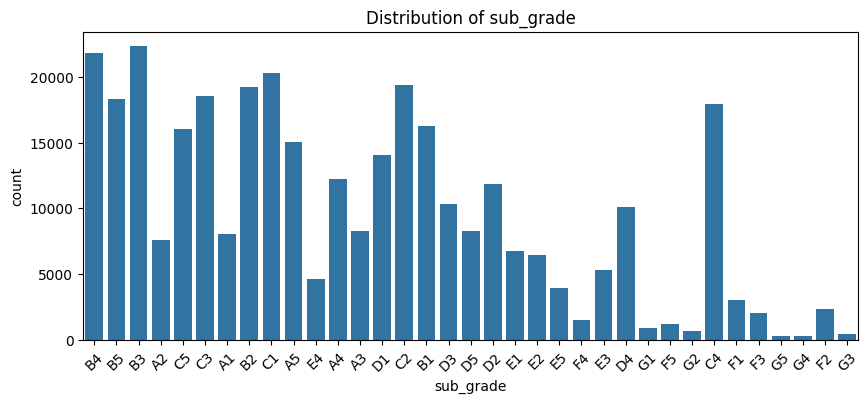

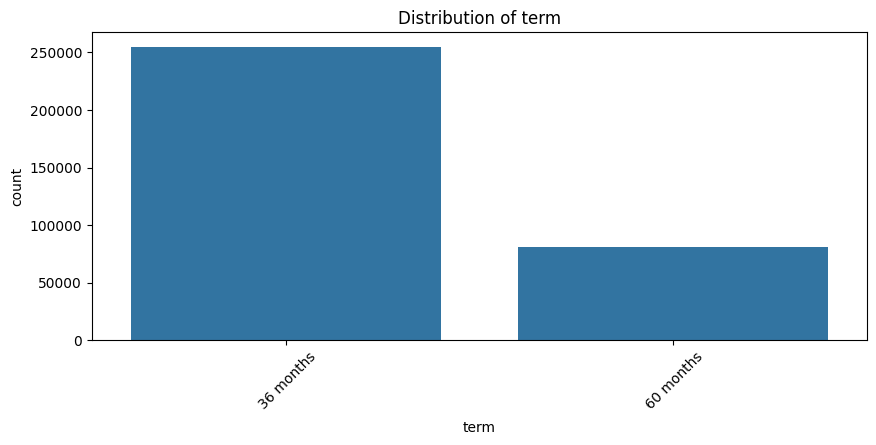

In [21]:
cat_vars = ['home_ownership', 'verification_status', 'loan_status', 'application_type', 'grade', 'sub_grade', 'term']
for i in cat_vars: 
    plt.figure(figsize=(10, 4))
    plt.title(f'Distribution of {i}')
    sns.countplot(data=df, x=i)
    plt.xticks(rotation = 45)
    plt.show()

All the application type is Individual

Most of the loan tenure is disbursed for 36 months

The grade of majority of people those who have took the loan is 'B' and have subgrade 'B3'.

So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

Most of the people took loan for 36 months and full paid on time

Most of people have home ownership as mortgage and rent

Most of the people took loan for debt consolidations

All the application type is Individual
Most of the loan tenure is disbursed for 36 months
The grade of majority of people those who have took the loan is 'B' and have subgrade 'B3'.
So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

### Outlier Treatment

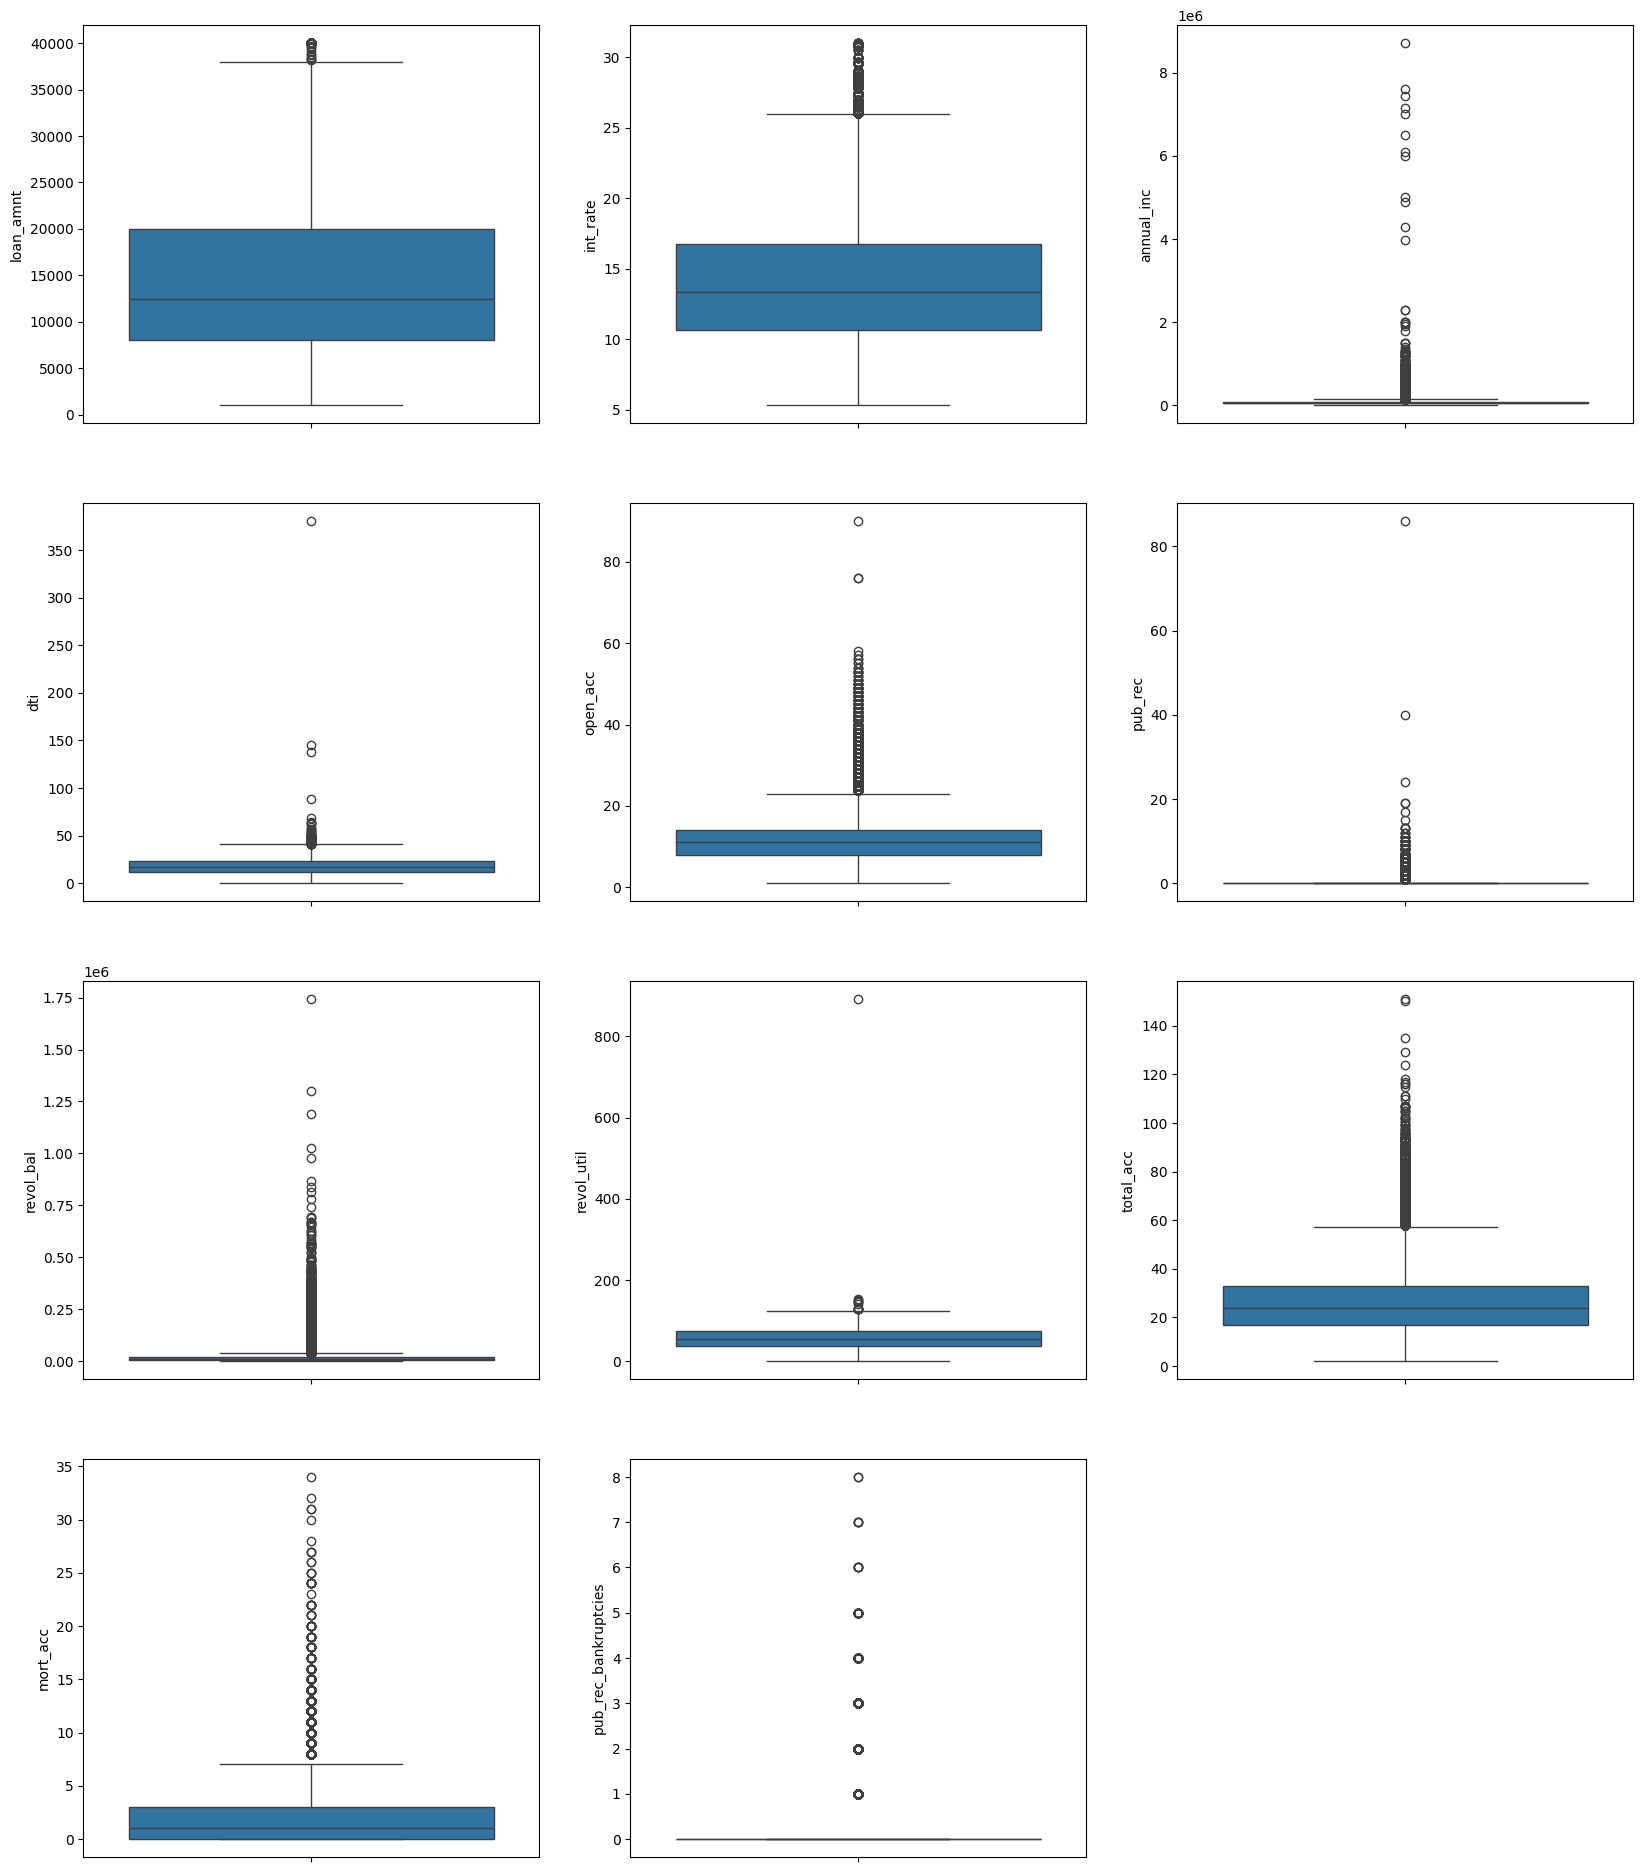

In [22]:
count = 0
plt.figure(figsize=(20,30))
for i in univariate_cols:
    count += 1
    plt.subplot(5,3,count)
    sns.boxplot(y= df[i])

In [23]:
df.shape

(335867, 26)

In [24]:
for col in univariate_cols:
    mean=df[col].mean()
    std=df[col].std()
    
    upper_limit=mean+3*std
    lower_limit=mean-3*std
    
    df=df[(df[col]<upper_limit) & (df[col]>lower_limit)]
    
df.shape

(312060, 26)

C:\Users\Rhythm Shah\AppData\Local\Temp\ipykernel_22880\2970726303.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


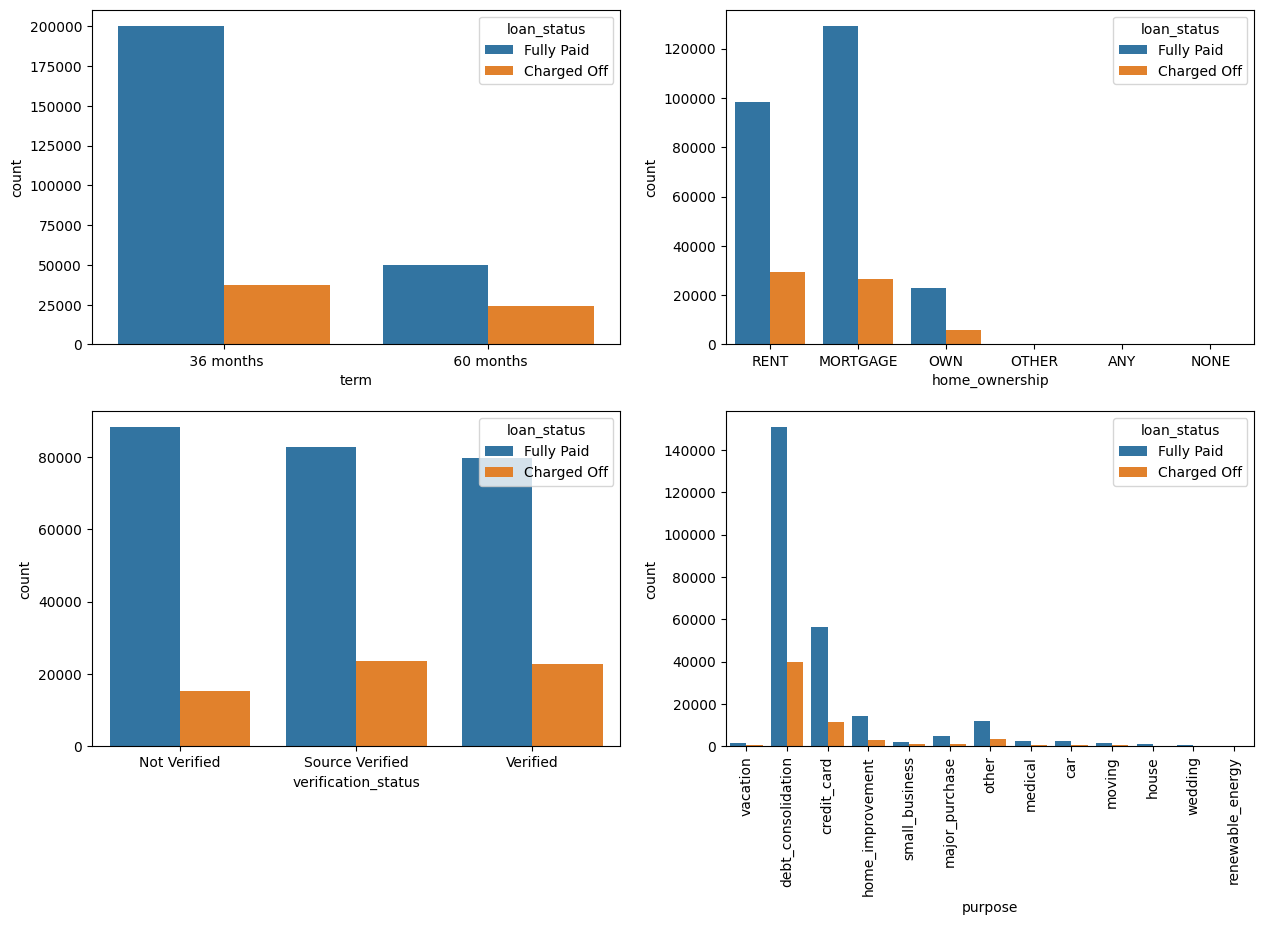

In [25]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=df,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=df,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=df,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=df,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.show()

Most of the people took loan for 36 months and full paid on time

Most of people have home ownership as mortgage and rent

Most of the people took loan for debt consolidations

4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

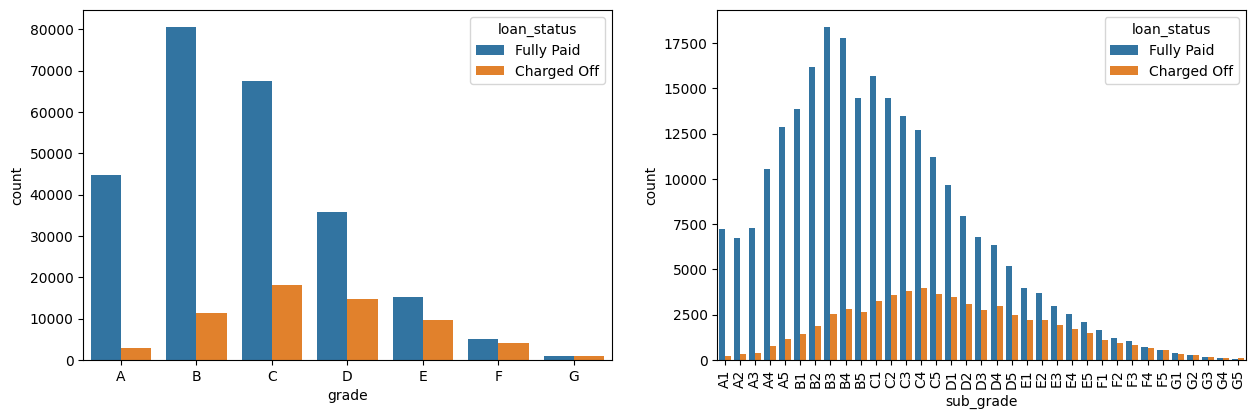

In [26]:
plt.figure(figsize=(15, 10))
warnings.filterwarnings("ignore")

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()


The grade of majority of people those who have fully paid the loan is 'B' and have subgrade 'B3'.

So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

5. Name the top 2 afforded job titles.

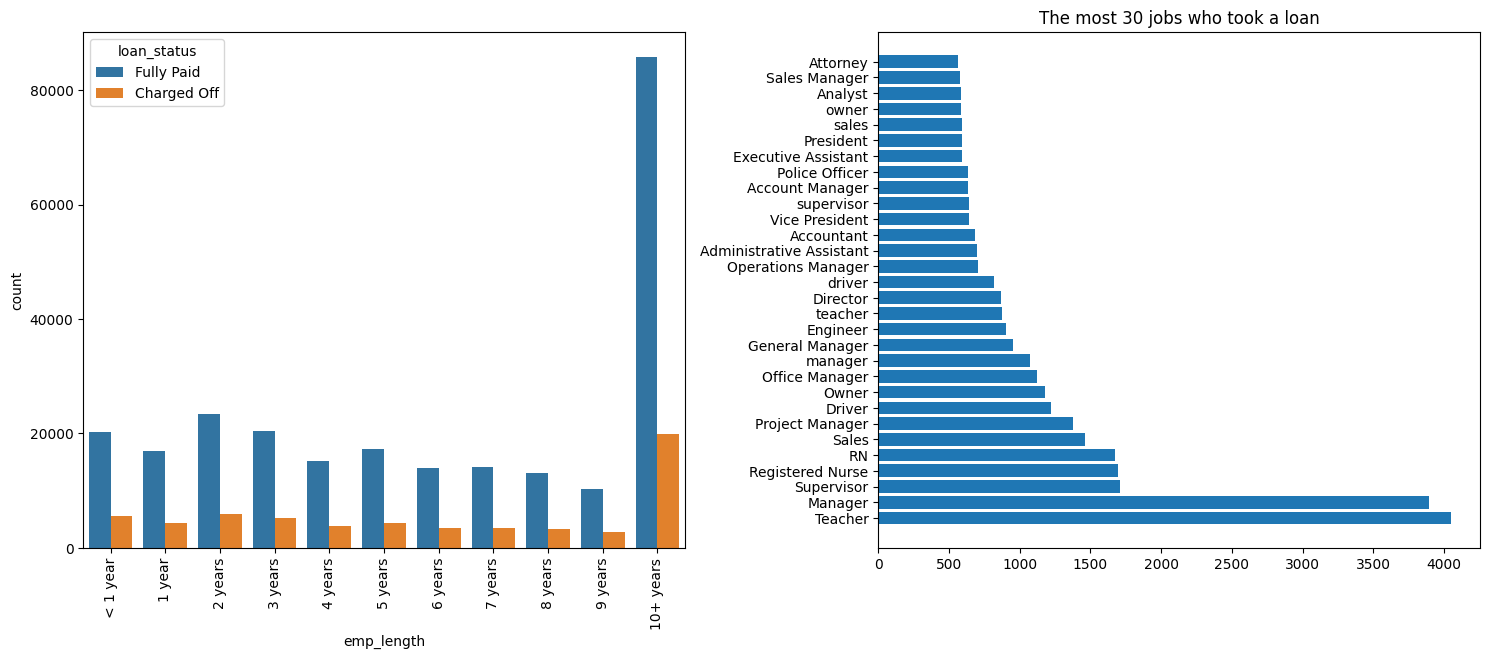

In [27]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=df,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(df.emp_title.value_counts()[:30].index,df.emp_title.value_counts()[:30])
plt.title("The most 30 jobs who took a loan")
plt.tight_layout()
plt.show()

Manager and Teacher are the most afforded loan on titles

Person who employed for more than 10 years has successfully paid of the loan

In [28]:
def f1(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def f2(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [29]:
df['pub_rec']=df.pub_rec.apply(f1)
df['mort_acc']=df.mort_acc.apply(f2)
df['pub_rec_bankruptcies']=df.pub_rec_bankruptcies.apply(f2)

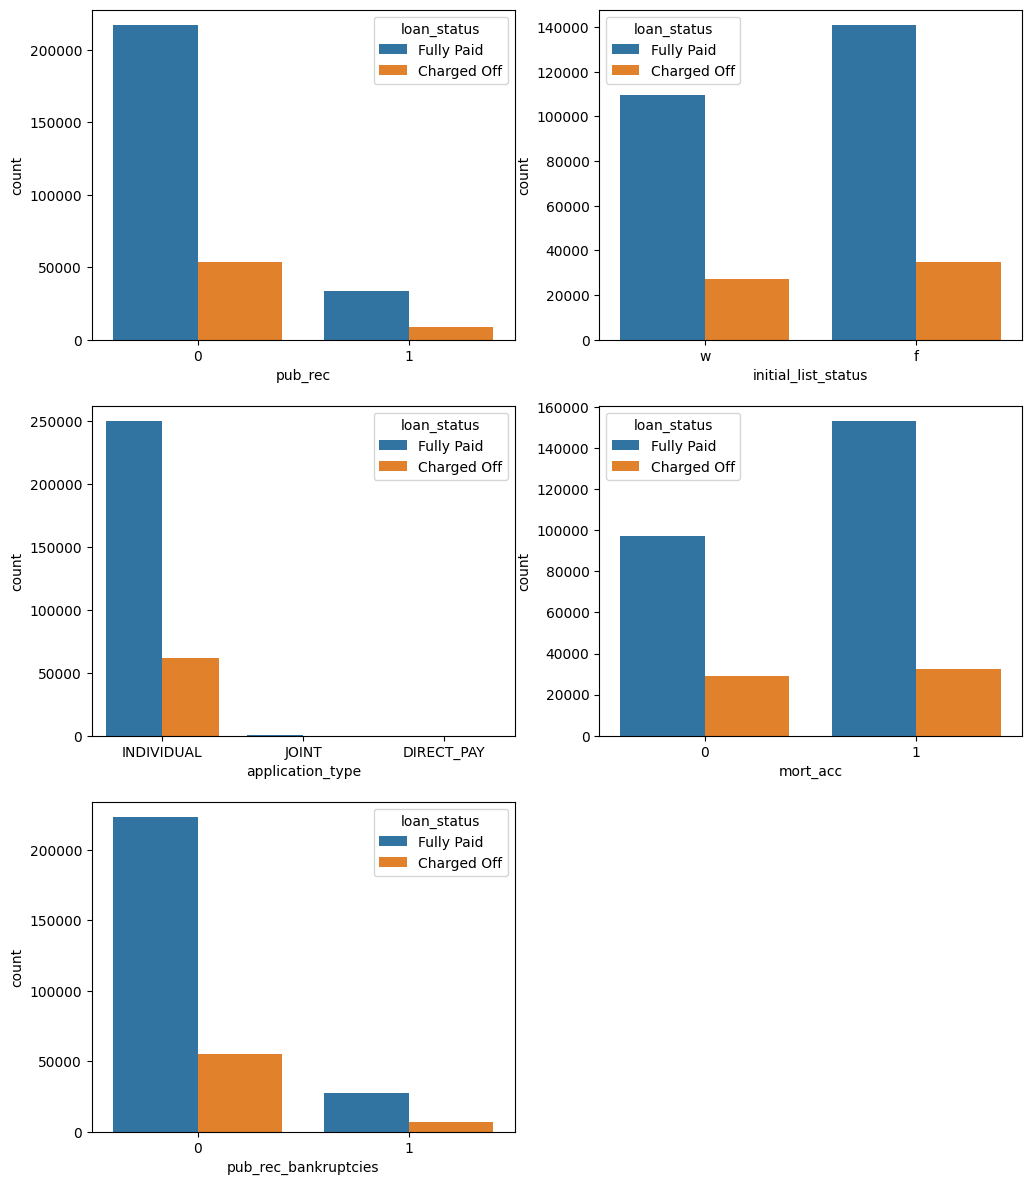

In [30]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=df,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=df,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=df,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=df,hue='loan_status')

plt.show()

Most the loan disbursed to the people whose do not hold bankrupties record have successfully paid loan


## Feature Engineering

In [31]:
for i in df.columns:
    print(i, '-->> ', df[i].unique(), '\n')

loan_amnt -->>  [10000.  8000. 15600. ... 36275. 34175. 36475.] 

term -->>  [' 36 months' ' 60 months'] 

int_rate -->>  [11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11  9.17
  6.62  8.39 21.98 12.29  7.9   6.97 15.61 13.35 12.12  9.99  8.19 18.75
 14.99 13.67 13.98 17.86 21.49 12.99 18.54 17.1  18.25 11.67  6.24  8.18
 12.35 14.16 18.55 22.15 15.99 24.99  9.67 19.19 21.   12.69 10.74  6.68
 19.22 16.99 16.55 19.97  7.89 24.7  16.49 25.78 25.83 13.99 15.22 15.31
  7.69 19.53 10.16  7.62  9.75 13.68 15.88 14.65 23.83 10.75 18.49 20.31
 17.57 27.31 22.99 14.33 13.53 22.45 14.64 24.5  17.99  9.16 12.49 11.55
 17.76 20.49 22.7  17.56  6.03  6.89 19.52  8.9  14.3   9.49 25.99 24.08
 13.05 14.98 16.59 10.15 25.89 21.99 23.99 11.49 14.47 11.53  8.67 13.49
  8.59 10.64 25.44  9.71 16.2  19.24 24.11 15.8  14.49 18.99 23.28 19.99
 18.24 14.09  9.25 19.05 17.77 18.92 13.65  7.12 16.78 14.46 12.59 16.24
 25.49  7.39 10.78 12.85 12.39 21.18 21.97  6.39  7.49 25.57 20.99 11.47
  

emp_title -->>  ['Marketing' 'Credit analyst ' 'Statistician' ...
 "Michael's Arts & Crafts" 'licensed bankere' 'Gracon Services, Inc'] 

emp_length -->>  ['10+ years' '4 years' '< 1 year' '6 years' '9 years' '2 years' '3 years'
 '7 years' '8 years' '5 years' '1 year'] 

home_ownership -->>  ['RENT' 'MORTGAGE' 'OWN' 'OTHER' 'ANY' 'NONE'] 

annual_inc -->>  [117000.  65000.  43057. ...  40311.  36111.  47212.] 

verification_status -->>  ['Not Verified' 'Source Verified' 'Verified'] 

issue_d -->>  ['Jan-2015' 'Nov-2014' 'Apr-2013' 'Sep-2015' 'Sep-2012' 'Oct-2014'
 'Apr-2012' 'Jun-2013' 'Dec-2015' 'Oct-2012' 'Jul-2014' 'Feb-2013'
 'Oct-2015' 'Jan-2014' 'Mar-2016' 'Apr-2014' 'Jun-2014' 'Oct-2013'
 'May-2013' 'Feb-2015' 'Jun-2015' 'Mar-2013' 'Jun-2016' 'Mar-2014'
 'Nov-2013' 'Dec-2014' 'Sep-2013' 'May-2016' 'Jul-2015' 'Apr-2015'
 'Jul-2013' 'Aug-2013' 'Aug-2014' 'Dec-2013' 'Mar-2012' 'Mar-2015'
 'Jul-2012' 'Feb-2014' 'Dec-2012' 'Sep-2014' 'Nov-2012' 'Apr-2016'
 'May-2012' 'May-2014' 'Jun-

In [32]:
# Converting term values to numerical val
term_values={' 36 months': 36, ' 60 months':60}
df['term'] = df.term.map(term_values)

# Mapping the target variable
df['loan_status'] = df.loan_status.map({'Fully Paid':0, 'Charged Off':1})

# Initial List Status
df['initial_list_status'].unique()
np.array(['w', 'f'], dtype=object)
list_status = {'w': 0, 'f': 1}
df['initial_list_status'] = df.initial_list_status.map(list_status)

# Let's fetch ZIP from address and then drop the remaining details -
df['zip_code'] = df.address.apply(lambda x: x[-5:]) 
df['zip_code'].value_counts(normalize=True)*100

for i in df.columns:
    print(i, '-->> ', df[i].unique(), '\n')

loan_amnt -->>  [10000.  8000. 15600. ... 36275. 34175. 36475.] 

term -->>  [36 60] 

int_rate -->>  [11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11  9.17
  6.62  8.39 21.98 12.29  7.9   6.97 15.61 13.35 12.12  9.99  8.19 18.75
 14.99 13.67 13.98 17.86 21.49 12.99 18.54 17.1  18.25 11.67  6.24  8.18
 12.35 14.16 18.55 22.15 15.99 24.99  9.67 19.19 21.   12.69 10.74  6.68
 19.22 16.99 16.55 19.97  7.89 24.7  16.49 25.78 25.83 13.99 15.22 15.31
  7.69 19.53 10.16  7.62  9.75 13.68 15.88 14.65 23.83 10.75 18.49 20.31
 17.57 27.31 22.99 14.33 13.53 22.45 14.64 24.5  17.99  9.16 12.49 11.55
 17.76 20.49 22.7  17.56  6.03  6.89 19.52  8.9  14.3   9.49 25.99 24.08
 13.05 14.98 16.59 10.15 25.89 21.99 23.99 11.49 14.47 11.53  8.67 13.49
  8.59 10.64 25.44  9.71 16.2  19.24 24.11 15.8  14.49 18.99 23.28 19.99
 18.24 14.09  9.25 19.05 17.77 18.92 13.65  7.12 16.78 14.46 12.59 16.24
 25.49  7.39 10.78 12.85 12.39 21.18 21.97  6.39  7.49 25.57 20.99 11.47
  7.26 14.31 24.24 23.

In [33]:
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,zip_code
0,10000.0,36,11.44,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,...,0,36369.0,41.8,25.0,0,INDIVIDUAL,0,0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",22690
1,8000.0,36,11.99,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,...,0,20131.0,53.3,27.0,1,INDIVIDUAL,1,0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",05113
2,15600.0,36,10.49,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,...,0,11987.0,92.2,26.0,1,INDIVIDUAL,0,0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",05113
3,7200.0,36,6.49,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,...,0,5472.0,21.5,13.0,1,INDIVIDUAL,0,0,"823 Reid Ford\r\nDelacruzside, MA 00813",00813
4,24375.0,60,17.27,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,...,0,24584.0,69.8,43.0,1,INDIVIDUAL,1,0,"679 Luna Roads\r\nGreggshire, VA 11650",11650


In [34]:
df['issue_d'].head()

0    Jan-2015
1    Jan-2015
2    Jan-2015
3    Nov-2014
4    Apr-2013
Name: issue_d, dtype: object

In [35]:
df['issue_month'] = df['issue_d'].apply(lambda x : str(x).split('-')[0])
df['issue_year'] = df['issue_d'].apply(lambda x : str(x).split('-')[1])

In [36]:
df = df.drop(columns=['issue_d'], axis=1)

In [37]:
df[['earliest_cr_line']].head()

,earliest_cr_line
0,Jun-1990
1,Jul-2004
2,Aug-2007
3,Sep-2006
4,Mar-1999


In [38]:
df['earliest_cr_line_month'] = df['earliest_cr_line'].apply(lambda x : str(x).split('-')[0])
df['earliest_cr_line_year'] = df['earliest_cr_line'].apply(lambda x : str(x).split('-')[1])

In [39]:
df = df.drop(columns=['earliest_cr_line'], axis=1)

In [40]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'title', 'dti', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'zip_code', 'issue_month', 'issue_year', 'earliest_cr_line_month',
       'earliest_cr_line_year'],
      dtype='object')

In [41]:
df = df.drop(columns=['address','zip_code','title',], axis=1)

In [42]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'dti', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'issue_month', 'issue_year',
       'earliest_cr_line_month', 'earliest_cr_line_year'],
      dtype='object')

In [43]:
for col in df.columns:
  print(col, '->', df[col].nunique())

loan_amnt -> 1383
term -> 2
int_rate -> 241
grade -> 7
sub_grade -> 35
emp_title -> 143140
emp_length -> 11
home_ownership -> 6
annual_inc -> 19887
verification_status -> 3
loan_status -> 2
purpose -> 13
dti -> 4045
open_acc -> 27
pub_rec -> 2
revol_bal -> 47298
revol_util -> 1135
total_acc -> 58
initial_list_status -> 2
application_type -> 3
mort_acc -> 2
pub_rec_bankruptcies -> 2
issue_month -> 12
issue_year -> 5
earliest_cr_line_month -> 12
earliest_cr_line_year -> 64


In [44]:
label_encoder = LabelEncoder()

In [45]:
df['term'] = label_encoder.fit_transform(df['term'])
df['grade'] = label_encoder.fit_transform(df['grade'])
df['sub_grade'] = label_encoder.fit_transform(df['sub_grade'])
df['emp_length'] = label_encoder.fit_transform(df['emp_length'])
df['home_ownership'] = label_encoder.fit_transform(df['home_ownership'])
df['verification_status'] = label_encoder.fit_transform(df['verification_status'])
df['loan_status'] = label_encoder.fit_transform(df['loan_status'])
df['purpose'] = label_encoder.fit_transform(df['purpose'])
df['pub_rec'] = label_encoder.fit_transform(df['pub_rec'])
df['initial_list_status'] = label_encoder.fit_transform(df['initial_list_status'])
df['application_type'] = label_encoder.fit_transform(df['application_type'])
df['mort_acc'] = label_encoder.fit_transform(df['mort_acc'])
df['pub_rec_bankruptcies'] = label_encoder.fit_transform(df['pub_rec_bankruptcies'])
df['open_acc'] = label_encoder.fit_transform(df['open_acc'])
df['issue_month'] = label_encoder.fit_transform(df['issue_month'])
df['issue_year'] = label_encoder.fit_transform(df['issue_year'])
df['earliest_cr_line_month'] = label_encoder.fit_transform(df['earliest_cr_line_month'])
df['earliest_cr_line_year'] = label_encoder.fit_transform(df['earliest_cr_line_year'])

In [46]:
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,earliest_cr_line_month,earliest_cr_line_year
0,10000.0,0,11.44,1,8,Marketing,1,5,117000.0,0,...,41.8,25.0,0,1,0,0,4,3,6,40
1,8000.0,0,11.99,1,9,Credit analyst,4,1,65000.0,0,...,53.3,27.0,1,1,1,0,4,3,5,54
2,15600.0,0,10.49,1,7,Statistician,10,5,43057.0,1,...,92.2,26.0,1,1,0,0,4,3,1,57
3,7200.0,0,6.49,0,1,Client Advocate,6,5,54000.0,0,...,21.5,13.0,1,1,0,0,9,2,11,56
4,24375.0,1,17.27,2,14,Destiny Management Inc.,9,1,55000.0,2,...,69.8,43.0,1,1,1,0,0,1,7,49


In [47]:
df1 = pd.DataFrame({'emp_title' : df['emp_title'], 'target' : df['loan_status']})
target_mean = df1.groupby(by=['emp_title'])['target'].mean()
df['emp_title'] = df1['emp_title'].map(target_mean)
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_month,issue_year,earliest_cr_line_month,earliest_cr_line_year
0,10000.0,0,11.44,1,8,0.240964,1,5,117000.0,0,...,41.8,25.0,0,1,0,0,4,3,6,40
1,8000.0,0,11.99,1,9,0.333333,4,1,65000.0,0,...,53.3,27.0,1,1,1,0,4,3,5,54
2,15600.0,0,10.49,1,7,0.200000,10,5,43057.0,1,...,92.2,26.0,1,1,0,0,4,3,1,57
3,7200.0,0,6.49,0,1,0.000000,6,5,54000.0,0,...,21.5,13.0,1,1,0,0,9,2,11,56
4,24375.0,1,17.27,2,14,1.000000,9,1,55000.0,2,...,69.8,43.0,1,1,1,0,0,1,7,49


In [48]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)

(218442, 25)
(93618, 25)


In [49]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

MinMaxScaler -
For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [50]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [75]:
y_pred = model.predict(X_test)

In [52]:
model.score(X_test,y_test)

0.8883013950308701

Accuracy of Logistic Regression Classifier on test set: 0.888

In [53]:
x_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, x_sm)
result = sm_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     8503.
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:29:23   Log-Likelihood:                -34693.
No. Observations:              218442   AIC:                         6.944e+04
Df Residuals:                  218416   BIC:                         6.971e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0225      0.020     -1.122      0.2

In [54]:
dic = {}
for coef, col in zip(model.coef_[0], df.columns):
  dic[col] = abs(coef)
a = sorted(dic.items(), key = lambda x: (x[1], x[0]))
for i in a:
  print(i)

('issue_year', 0.00456714534578184)
('loan_status', 0.011176908794713572)
('pub_rec_bankruptcies', 0.023389120417974012)
('issue_month', 0.047701926039003424)
('grade', 0.05170318341278431)
('verification_status', 0.06319578744910836)
('total_acc', 0.08641689774049566)
('annual_inc', 0.0977822765509364)
('application_type', 0.10787115506537491)
('earliest_cr_line_month', 0.1283548118959878)
('open_acc', 0.13003336325452106)
('emp_length', 0.1501358949257413)
('mort_acc', 0.19879094359684973)
('home_ownership', 0.2639314249331047)
('revol_util', 0.4243464562687922)
('term', 0.4262550662994685)
('pub_rec', 0.4588173410020658)
('loan_amnt', 0.5952418785532139)
('revol_bal', 0.7822503571456346)
('dti', 0.8448560919194711)
('purpose', 1.0330763651936297)
('initial_list_status', 1.2157771845681498)
('int_rate', 3.279122936360776)
('sub_grade', 5.723287773324654)
('emp_title', 8.673865421293499)


[[73000  2092]
 [ 8365 10161]]


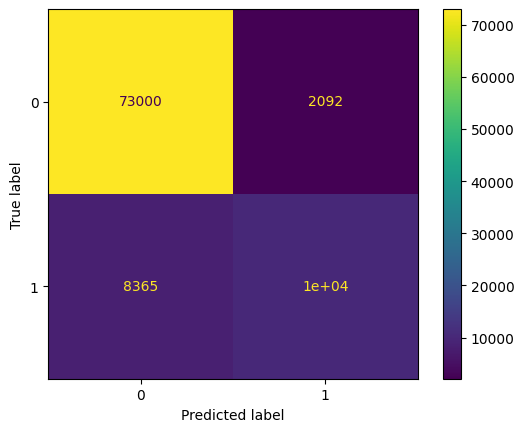

In [55]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

There is significant value for false negative and false positive. Which will hamper our prediction due to type-1 or type-2 error.


In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     75092
           1       0.83      0.55      0.66     18526

    accuracy                           0.89     93618
   macro avg       0.86      0.76      0.80     93618
weighted avg       0.88      0.89      0.88     93618



Precision score and recall score for full paid status is almost same indicates that model is doing decent job which correctly classified the both of the scenarios

Precision score for charged off status is more than recall score which is perfect

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218442, 25), (93618, 25), (218442,), (93618,))

ROC Curve -
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

TPR=(TP)/(TP+FN)
False Positive Rate (FPR) is defined as follows:

FPR=(FP)/(FP+TN)
An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

AUC (Area under the ROC Curve) -
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions.

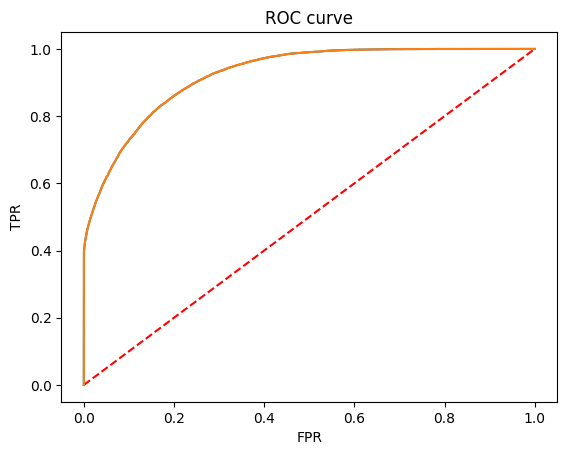

In [58]:
prob = (model.predict_proba(X_test))[:,1]
fpr, tpr, thr = roc_curve(y_test, prob)
logit_roc_auc = roc_auc_score(y_test,model.predict(X_test))

plt.plot(fpr,tpr)
plt.plot(fpr,fpr,'--',color='red' )
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

ROC-AUC curve is grossing the area which indicates that model is performing well.
There is still room for some model improvement

By collecting more data, using a more complex model, or tuning the hyperparameters, it is possible to improve the model's performance.

In [59]:
roc_auc_score(y_test,prob)

0.9235783931593985

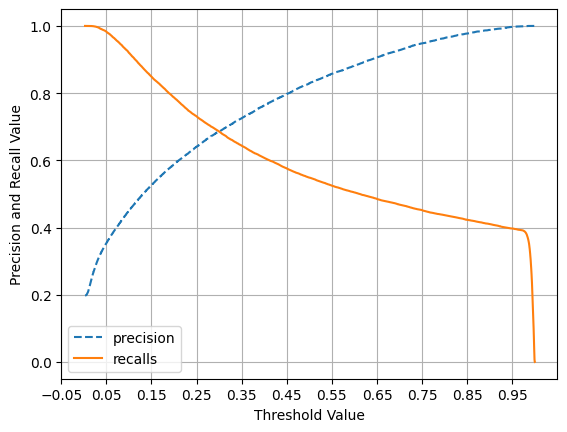

In [60]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
    
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,model.predict_proba(X_test)[:,1])

Multicollinearity check using Variance Inflation Factor (VIF) -
Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF. In VIF method, we pick each independent feature and regress it against all of the other independent features. VIF score of an independent variable represents how well the variable is explained by other independent variables.

In [61]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
2,int_rate,407.60
4,sub_grade,245.48
18,application_type,187.12
3,grade,64.70
24,earliest_cr_line_year,58.98


In [62]:
X.drop(columns=['int_rate'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
17,application_type,105.68
3,sub_grade,89.62
2,grade,64.66
23,earliest_cr_line_year,58.63
15,total_acc,13.26


In [63]:
X.drop(columns=['application_type'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
3,sub_grade,88.98
2,grade,63.94
22,earliest_cr_line_year,26.43
15,total_acc,12.82
11,open_acc,12.09


In [64]:
X.drop(columns=['sub_grade'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
21,earliest_cr_line_year,25.85
14,total_acc,12.82
10,open_acc,12.08
13,revol_util,8.91
6,annual_inc,8.25


In [65]:
X.drop(columns=['earliest_cr_line_year'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
14,total_acc,12.74
10,open_acc,11.56
6,annual_inc,8.11
9,dti,8.02
13,revol_util,7.98


In [66]:
X.drop(columns=['total_acc'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
13,revol_util,7.98
6,annual_inc,7.89
9,dti,7.84
10,open_acc,7.39
0,loan_amnt,7.33


In [67]:
X=scaler.fit_transform(X)

kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(model,X,y,cv=kfold,scoring='accuracy',n_jobs=-1))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.888


In [68]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [69]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (350428, 25)
After OverSampling, the shape of train_y: (350428,) 

After OverSampling, counts of label '1': 175214
After OverSampling, counts of label '0': 175214


In [70]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)
  
# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90     75092
           1       0.57      0.80      0.67     18526

    accuracy                           0.84     93618
   macro avg       0.76      0.83      0.78     93618
weighted avg       0.87      0.84      0.85     93618



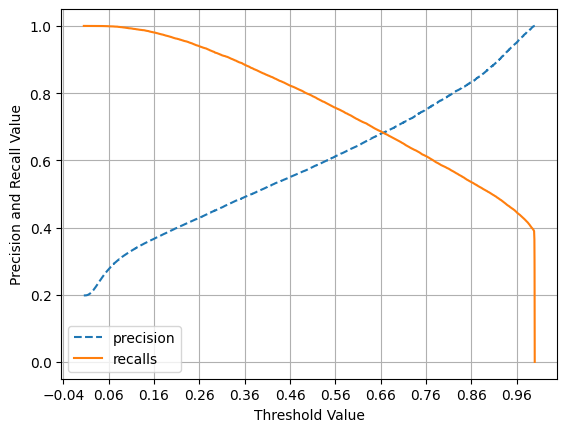

In [71]:
precission_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

In [76]:
df = pd.read_csv('logistic_regression.csv')

1. What percentage of customers have fully paid their Loan Amount?

In [77]:
df ['loan_status'].value_counts(normalize=True)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: proportion, dtype: float64

80%

2. Comment about the correlation between Loan Amount and Installment features.


The spearman correlation coefficient between Loan Amount and Installmen is very high (i.e. 0.97)

3. The majority of people have home ownership as _______.

In [78]:
df ['home_ownership'].value_counts(normalize=True)*100

home_ownership
MORTGAGE    50.084085
RENT        40.347953
OWN          9.531096
OTHER        0.028281
NONE         0.007828
ANY          0.000758
Name: proportion, dtype: float64

In [79]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

Mortgage

4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

True.

Out of all people with grade 'A', 93% got their loan approved.

5. Name the top 2 afforded job titles.

Teacher & Manager

6. Thinking from a bank's perspective, which metric should our primary focus be on..
ROC AUC
Precision
Recall
F1 Score

It should be on f1 score.  as we need to give importance to both precision and recall. We don't want to miss potential customers and at the same time we also don't want to give loan to defaulters

7. How does the gap in precision and recall affect the bank?


Recall score: 0.94 and Precision score: 0.85. Which tells us that there are more false positives than the false negatives.

From Confusion Matrix it can be seen that FP = 10% of total cases & FN = 0.9% of Total Cases

If Recall value is low (i.e. FN are high), it means Bank is loosing in opportunity cost.

If Precision value is low (i.e. FP are high), it means Bank's NPA (defaulters) may increase.

8. Which were the features that heavily affected the outcome?

Using RFE we were able to identify top_20 features which has high impact on Outcome. This include:

int_rate: Interest Rate

sub_grade: loan subgrade

term : number of payments on the loan

home_ownership

purpose

application_type

pincode (from address)

emp_title: job title supplied by the Borrower

9. Will the results be affected by geographical location? (Yes/No)

pincode (derived from address) has significant impact on the outcome.

How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

Answer - Since data is imbalances by making the data balance we can try to avoid false positives. For evaluation metrics, we should be focusing on the macro average f1-score because we don't want to make false positive prediction and at the same we want to detect the defualers.
Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone

Answer - Below are the most features and their importance while making the prediction. So these variables can help the managers to identify which are customers who are more likely to pay the loan amount fully,

## Actional Insights and Recommendations


80% of the customers have paid the loan fully.

20% of the customers are the defaulters.

The organization can the trained model to make prediction for whether a person will likely to pay the loan amount or he will be a defaulter.

Cross Validation accuracy and testing accuracy is almost same which infers model is performing the decent job. We can trust this model for unseen data

By collecting more data, using a more complex model, or tuning the hyperparameters, it is possible to improve the model's performance.

ROC AUC curve area of 0.73, the model is correctly classifying about 73% of the instances. This is a good performance, but there is still room for improvement.

The precision-recall curve allows us to see how the precision and recall trade-off as we vary the threshold. A higher threshold will result in higher precision, but lower recall, and vice versa. The ideal point on the curve is the one that best meets the needs of the specific application.

After balancing the dataset, there is significant change observed in the precion and recall score for both of the classes.

Accuracy of Logistic Regression Classifier on test set: 0.888 which is decent and not by chance.